# Graph embedding using SkipGram

This is an embedding of the whole graph, no training and validation split and all sources.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

In [2]:
exp_name = "80_20_kg_covid_19_20201001_training_test_epoch_500_delta_0.0001"
graph_data_dir = "graph_20201001"

## Loading the graphs
We load the kg-covid-19 graph from the repository as an undirected graph.

In [3]:
import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)
if not os.path.exists(graph_data_dir + "/kg-covid-19.tar.gz"):
    with urllib.request.urlopen("https://kg-hub.berkeleybop.io/kg-covid-19/20201001/kg-covid-19.tar.gz") as response, \
        open(graph_data_dir + "/kg-covid-19.tar.gz", 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [4]:
import os
os.system("tar -xvzf " + graph_data_dir + "/kg-covid-19.tar.gz -C " + graph_data_dir)

0

#### only need to do this once, b/c we'll load the sorted.tsv from now on once it is made below

In [5]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists("kg_covid_19_sorted.tsv"):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = graph_data_dir + "/merged-kg_edges.tsv",
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = graph_data_dir + "/merged-kg_nodes.tsv",
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges("kg_covid_19_sorted.tsv",
        sources_column="subject",
        destinations_column="object")

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 468 ms


As first thing, we print a short report showing all the avalable graph details, including the number of edges, nodes, trap nodes and both the connected components and the strongly connected components.

In [6]:
from ensmallen_graph import EnsmallenGraph
 
graph = EnsmallenGraph.from_sorted_csv(
    edge_path = "kg_covid_19_sorted.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=377577,  # should be = or > than actual number
    edges_number=30949369,   # same ^
    # cached_edges_number=int(30949369/100*5), # deprecated
    node_path = graph_data_dir + "/merged-kg_nodes.tsv",
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

{'unique_node_types_number': '37',
 'density': '0.037284237441157525',
 'unique_edge_types_number': '0',
 'nodes_number': '377577',
 'self_loops_number': '481',
 'directed': 'false',
 'singletons': '8314',
 'edges_number': '30949369',
 'self_loops_rate': '0.00001554151233261008',
 'degree_mean': '81.96836406878597'}

The followings are check that are not necessary, but are offered as sanity checks:

### Considered parameters
We are going to use the following parameters:

- **Walk lengths:** $100$ nodes.
- **Batch size:** $2^{7} = 128$ walks per batch.
- **Walk iterations:** $20$ iterations on the graph.
- **Window size:** $4$ nodes, meaning $4$ on the left and $4$ on the right of the center nodes. Consider that the first *window_size* values on the left and the right of the walks will be trimmed.
- **Return weight, inverse of $p$:** $1.0$.
- **Explore weight, inverse of $q$:** $1.0$.
- **Embedding size:** $100$.
- **Negative samples:** For the porpose of the [NCE function negative samples](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss), we are going to use $10$. These are the number of negative classes to randomly sample per batch. This single sample of negative classes is evaluated for each element in the batch.
- **Optimizer:** [Nadam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam).
- **Early stopping parameters:** We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.
- **Epochs:** The model will be trained up to $1000$ epochs.
- **Learning rate:** default

In [7]:
%%time
training, validation = graph.connected_holdout(0.80, seed=42)

CPU times: user 3min 33s, sys: 888 ms, total: 3min 34s
Wall time: 3min 33s


In [8]:
training.report()

{'degree_mean': '65.5746880768691',
 'edges_number': '24759494',
 'nodes_number': '377577',
 'self_loops_number': '370',
 'directed': 'false',
 'self_loops_rate': '0.000014943762582547123',
 'singletons': '8324',
 'unique_edge_types_number': '0',
 'unique_node_types_number': '37',
 'density': '0.029827388507304143'}

In [9]:
validation.report()

{'edges_number': '6189875',
 'singletons': '156519',
 'unique_node_types_number': '37',
 'density': '0.007456848933853383',
 'unique_edge_types_number': '0',
 'directed': 'false',
 'self_loops_number': '111',
 'nodes_number': '377577',
 'degree_mean': '16.39367599191688',
 'self_loops_rate': '0.000017932510753448172'}

In [10]:
%%time
coherence_check=False
if coherence_check:
    assert graph.contains(training)
    assert graph.contains(validation)
    assert (training | validation).contains(graph)
    assert graph.contains(training | validation)
    assert not training.overlaps(validation)
    assert not validation.overlaps(training)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


#### Setting up the parameters

In [11]:
walk_length=100
batch_size=2**9
iterations=20
window_size=4
p=1.0
q=1.0
embedding_size=100
negatives_samples=30
patience=5
delta=0.0001
epochs=500

#### Creating the training and validation Keras sequences

## Creating the SkipGram model
We are going to setup the model to use, if available, multiple GPUs.

In [12]:
from embiggen import Node2VecSequence

training_sequence = Node2VecSequence(
    training,
    walk_length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

validation_sequence = Node2VecSequence(
    graph, # Here we use the entire graph. This will only be used for the early stopping.
    walk_length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

In [13]:
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.optimizers import Nadam
from embiggen import SkipGram

# strategy = MirroredStrategy()
# with strategy.scope():
model = SkipGram(
    vocabulary_size=training.get_nodes_number(),
    embedding_size=embedding_size,
    window_size=window_size,
    negative_samples=negatives_samples,
)

model.summary()

Model: "SkipGram"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       37757700    words_embedding[0][0]            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 8)]          0                                            
___________________________________________________________________________________________

## Tuning the SkipGram model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    training_sequence,
    steps_per_epoch=training_sequence.steps_per_epoch,
    validation_data=validation_sequence,
    validation_steps=validation_sequence.steps_per_epoch,
    epochs=epochs,
    callbacks=[
        EarlyStopping(
            "val_loss",
            min_delta=delta,
            patience=patience,
            restore_best_weights=True
        )
    ]
)

Epoch 1/500
722/722 [==============================] - 1185s 2s/step - loss: 177.0404 - val_loss: 195.2658
Epoch 2/500
722/722 [==============================] - 1172s 2s/step - loss: 127.0025 - val_loss: 185.6311
Epoch 3/500
722/722 [==============================] - 1186s 2s/step - loss: 112.6488 - val_loss: 177.6938
Epoch 4/500
722/722 [==============================] - 1190s 2s/step - loss: 102.9787 - val_loss: 171.8963
Epoch 5/500
722/722 [==============================] - 1184s 2s/step - loss: 97.0606 - val_loss: 169.7232
Epoch 6/500
722/722 [==============================] - 1191s 2s/step - loss: 91.4214 - val_loss: 165.0681
Epoch 7/500
722/722 [==============================] - 1200s 2s/step - loss: 85.7749 - val_loss: 160.7493
Epoch 8/500
722/722 [==============================] - 1188s 2s/step - loss: 80.8782 - val_loss: 157.4284
Epoch 9/500
722/722 [==============================] - 1186s 2s/step - loss: 76.6870 - val_loss: 155.1093
Epoch 10/500
722/722 [====================

722/722 [==============================] - 1167s 2s/step - loss: 24.0975 - val_loss: 116.6870
Epoch 78/500
722/722 [==============================] - 1169s 2s/step - loss: 23.8374 - val_loss: 116.4813
Epoch 79/500
722/722 [==============================] - 1182s 2s/step - loss: 23.6059 - val_loss: 115.8010
Epoch 80/500
722/722 [==============================] - 1181s 2s/step - loss: 24.5165 - val_loss: 116.3202
Epoch 81/500
722/722 [==============================] - 1176s 2s/step - loss: 23.5118 - val_loss: 117.1147
Epoch 82/500
722/722 [==============================] - 1172s 2s/step - loss: 22.8529 - val_loss: 116.3565
Epoch 83/500
722/722 [==============================] - 1171s 2s/step - loss: 23.0504 - val_loss: 116.6978
Epoch 84/500
722/722 [==============================] - 1175s 2s/step - loss: 22.9848 - val_loss: 116.7648


### Saving the model weights

In [15]:
model.save_weights(f"{model.name}_" + exp_name + "_weights.h5")

### Visualizing the training history
We can visualize the performance of the model during the training process as follows:

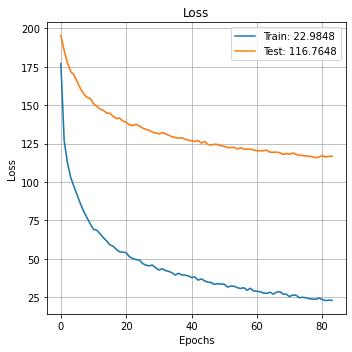

In [16]:
from plot_keras_history import plot_history

plot_history(history)

There may be some hiccups in the plot of the history if the model is reloaded from stored weights: [this is a known Keras issue](https://github.com/keras-team/keras/issues/4875) and is not related to either the holdouts used or the model.

## Saving the obtained embeddings
Finally we save our hard earned model embeddings. In another notebook we will show how to do link prediction on the obtained embedding.

In [17]:
import numpy as np

np.save(f"{model.name}_" + exp_name + "_embedding.npy", model.embedding)